# Model AOPs

First attempt at modeling AOPs.  For not will now use hill curves because the data is very noisy and don't know how
to assess goodness-of-fit.

Instead a simple approach could be done as follows

1) get chemical response data for target
2) use curveP to correct noise and establish monotonicity
3) put all concentrations on same scale

Imports...

In [ ]:
import pandas as pd
import config
import seaborn as sns
import numpy as np
from curvep import curveP, CONCLIST
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


sns.set(style="ticks", context="talk")
plt.style.use("dark_background")



### Get data

First get all the AIDs associated with a set of targets.

This part can be modified once its decided how assays will be grouped.  E.g, here ESR1, ESR2 will represent two different AOPs, pathways, etc.

In [ ]:
# get AIDs associated with target
TARGETS = ['ESR1', 'ESR2']
TARGETS_STR_LIST = ["\'" + t + "\'" for t in TARGETS]
TARGETS_STR = ", ".join(map(str, TARGETS_STR_LIST))
targets_array = f'({TARGETS_STR})'

# get assays that belong to a particular
# target
query = 'SELECT tG.PUBCHEM_AID, tG.GeneSymbol ' \
        'FROM targets tG ' \
        'WHERE GeneSymbol in {}' \
        ''.format(targets_array)

genes_aids = pd.read_sql_query(query, con=config.Config.DB_URI)

# get active compounds in AIDS

aid_list = [str(aid)for aid in genes_aids.PUBCHEM_AID]

aid_string = ", ".join(map(str, aid_list))
aid_query = f'({aid_string})'

actives_query = 'SELECT c.PUBCHEM_CID as CID, c.PUBCHEM_AID as AID, c.PUBCHEM_SID as SID ' \
                'FROM concise c ' \
                'WHERE c.PUBCHEM_AID in {} AND c.PUBCHEM_ACTIVITY_OUTCOME == "Active" AND ' \
                'c.PUBCHEM_CID is not null AND c.PUBCHEM_SID is not null'.format(aid_query)

active_cmps = pd.read_sql_query(actives_query, con=config.Config.DB_URI)
active_cmps['SID'] = active_cmps['SID'].astype(int)

sid_list = [str(sid)for sid in active_cmps.SID]

sid_string = ", ".join(map(str, sid_list))
sid_query = f'({sid_string})'

dr_query = 'SELECT  SID, AID, concentration as conc, response as resp ' \
                'FROM dose_response ' \
                'WHERE AID in {} AND SID in {} '.format(aid_query, sid_query)

dose_responses = pd.read_sql_query(dr_query, con=config.Config.DB_URI)

# this merge is necessary because
# the former query gathers all data
# for all sid and aid that have any active cmps
# not just the pairs of active sid, aid
# could be solved by a SQLite join, but
# right now takes too long
dr_merged = pd.merge(dose_responses, active_cmps[['SID', 'CID', 'AID']].drop_duplicates(['SID', 'CID', 'AID']), on=['SID', 'AID'])
print(dr_merged.head())



      SID  AID    conc    resp      CID
0  842142  713  1.5625   1.160  5770444
1  842142  713  1.5625  83.107  5770444
2  842142  713  3.1250   1.040  5770444
3  842142  713  3.1250  66.953  5770444
4  842142  713  6.2500   1.130  5770444


One of the first attempts at standardizing different concentrations between assays is "binning" concentrations by rounding to two decimals.  This is important at least because some assays report concentrations with high preciesion....in order to responses that different by decimals...

In [ ]:
dr_merged['log(conc)'] = np.log10(dr_merged.conc)

dr_merged['log(conc)'] = dr_merged['log(conc)'].round(2)

# average multiple responses per concentration
# then apply curveP to correct points
response_avg = dr_merged.groupby(['AID', 'CID', 'log(conc)'])['resp'].mean().reset_index()
response_avg_corrected = response_avg.groupby(['AID', 'CID']).apply(curveP).reset_index(drop=True)
response_avg_corrected.head()

,AID,CID,log(conc),resp
0,713,2406,0.19,39.6215
1,713,2406,0.49,29.6565
2,713,2406,0.80,17.5800
3,713,2406,1.10,0.0000
4,713,2406,1.40,0.0000


The second part of standardizing concentrations between assays involved putting them all on the same scale.

The way this is currently behind handled is using the 45 different concentrations ToxCast/Tox21 assays were tested for each compound.  If a chemical wasn't tested at that concentration just impute with the closet smaller concentration.

If we do hill modeling, this would be uneccesary.

In [ ]:
# put all concentrations on same scale
scaled_data = []
scaled_concentrations = pd.Index(np.round(np.log10(CONCLIST), 2))
scaled_concentrations.name = 'log(conc)'

response_avg_corrected = response_avg_corrected.sort_values(['AID', 'CID', 'log(conc)'])
for gp, data in response_avg_corrected.groupby(['AID', 'CID']):
    new_data = data[['log(conc)', 'resp']].set_index('log(conc)').drop_duplicates()

    new_data = new_data.reindex( scaled_concentrations, method='ffill' ).fillna(0)
    new_data['AID'] = gp[0]
    new_data['CID'] = gp[1]
    scaled_data.append(new_data.reset_index())

scaled_data = pd.concat(scaled_data)

# use curveP one more time

scaled_data_corrected = scaled_data.groupby(['AID', 'CID']).apply(curveP).reset_index(drop=True)

scaled_data_corrected.head()

,log(conc),resp,AID,CID
0,-6.00,0.0,713,2406
1,-5.57,0.0,713,2406
2,-5.40,0.0,713,2406
3,-5.22,0.0,713,2406
4,-5.04,0.0,713,2406


Now, create an example model just using one compound....

This can be extended to create models for $n$ compounds when ready...

In [19]:
counts = scaled_data_corrected.groupby('CID')['AID'].nunique().sort_values()

scaled_data_corrected = scaled_data_corrected.merge(genes_aids.rename(columns={'PUBCHEM_AID': 'AID', 'GeneSymbol': 'Target'}))

example_cid = 73864

training_data = scaled_data_corrected.query(f"CID == {example_cid}")

In [20]:
training_data

,log(conc),resp,AID,CID,Target
25110,-6.00,0.000000,588513,73864,ESR1
25111,-5.57,0.000000,588513,73864,ESR1
25112,-5.40,0.000000,588513,73864,ESR1
25113,-5.22,0.000000,588513,73864,ESR1
25114,-5.04,0.000000,588513,73864,ESR1
...,...,...,...,...,...
181435,1.30,64.641900,1259383,73864,ESR1
181436,1.47,64.641900,1259383,73864,ESR1
181437,1.65,70.329344,1259383,73864,ESR1
181438,1.82,70.329344,1259383,73864,ESR1


Text(0.5, 1.0, 'Avg. Dose Responses for\nTarget ESR2 and CID 73864')

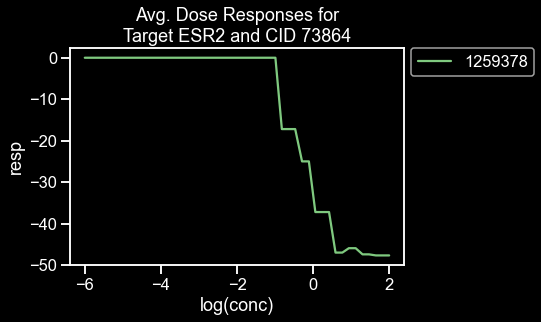

In [26]:
#sns.scatterplot(data=training_data, x='log(conc)', y='resp', hue='AID', legend=False, palette='Accent')

target = TARGETS[1]
sns.lineplot(data=training_data.query(f'Target == "{target}"'), x='log(conc)', y='resp', hue='AID', palette='Accent')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f"Avg. Dose Responses for\nTarget {target} and CID {example_cid}")

In [27]:
# create the F matrix

F_matrix = pd.DataFrame(index=genes_aids.PUBCHEM_AID.unique().astype(int), columns=genes_aids.GeneSymbol.unique())

for aop, aop_data in genes_aids.groupby('GeneSymbol'):
    for aid in aop_data.PUBCHEM_AID.unique():
        F_matrix.loc[aid, aop] = 1
F_matrix = F_matrix.fillna(0)
F_matrix


,ESR1,ESR2
713,1,0
737,1,0
1078,1,0
1079,1,0
1223,1,0
588513,1,0
588514,1,0
743069,1,0
743075,1,0
743079,1,0


In [28]:
training_wide = training_data.pivot(columns='log(conc)', index='AID', values='resp')
training_wide.shape

(9, 45)

In [29]:
# fill missing data AIDs
training_wide = training_wide.reindex(F_matrix.index).fillna(0)

In [30]:
# check scales, will need to normalize to 0-1 eventually

training_wide.max(1)

713         0.000000
737         0.000000
1078        0.000000
1079        0.000000
1223        0.000000
588513      0.000000
588514     67.011800
743069      0.000000
743075     21.066041
743079     85.737800
743080      0.000000
1259244     0.000000
1259383    70.329344
733         0.000000
1060        0.000000
1221        0.000000
1259377     0.000000
1259378     0.000000
dtype: float64

In [31]:

EPOCHS = 750
STEPS = 100
INITIAL_LR = 1
GAMMA = 0.5

F = torch.tensor(F_matrix.values, dtype=torch.float)
R = torch.tensor(np.random.random(size=(F.shape[1], training_wide.shape[1])),
                 dtype=torch.float, requires_grad=True)

# R = torch.tensor(torch.clamp(R, min=0, max=1), requires_grad=True)


y = torch.tensor(training_wide.values)

optimizer = optim.Adam([R], lr=INITIAL_LR)
#scheduler = StepLR(optimizer, step_size=STEPS, gamma=0.9)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=50)

In [32]:
losses = np.array([])

for epoch in range(EPOCHS):
    # model is y = FR
    optimizer.zero_grad()
    #R = torch.clamp(R, min=0, max=1)
    model = torch.tensordot(F, R, dims=([1], [0]))


    ss_term = torch.mean(torch.square(model - y))

    x = torch.sum(R)
    penalty_term = x ** 10 / (x ** 10 + 0.5 ** 10)

    loss = ss_term + penalty_term
    loss = ss_term

    loss.backward()
    optimizer.step()
    losses = np.append(losses, loss.detach().numpy())
#     if losses[-50:].var() < 0.1 and epoch>10:
#         #print("Reducing LR...")
#         for g in optimizer.param_groups:
#             g['lr'] = g['lr']*GAMMA
    scheduler.step(loss)
    if epoch % STEPS == 0:
        print(loss)
        print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

tensor(233.8789, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-0 lr: 1
tensor(208.7584, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-100 lr: 1
tensor(208.7581, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-200 lr: 0.010000000000000002
tensor(208.7581, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-300 lr: 0.00010000000000000003
tensor(208.7581, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-400 lr: 1.0000000000000004e-06
tensor(208.7581, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-500 lr: 1.0000000000000005e-08
tensor(208.7581, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-600 lr: 1.0000000000000005e-08
tensor(208.7581, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-700 lr: 1.0000000000000005e-08


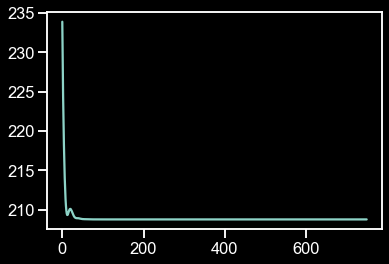

In [33]:
plt.plot(losses)
plt.show()

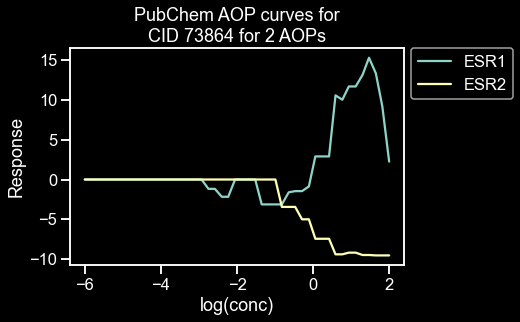

In [40]:
scores = pd.DataFrame(R.detach().numpy(),
                      index=F_matrix.columns,
                      columns=training_wide.columns).T.reset_index().melt(id_vars='log(conc)')
scores = scores.rename(columns={'variable': 'Target', 'value': 'Response'})
sns.lineplot(data=scores, x='log(conc)', y='Response', hue='Target')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(f"PubChem AOP curves for\nCID {example_cid} for {len(TARGETS)} AOPs")

plt.show()